# 泰坦尼克号生还者预测
根据给定的数据对失事乘客进行生还概率进行预测。
### 特征定义
给定的数据中各个字段的含义：
- **PassengerId：** 乘客ID
- **Pclass：** 乘客等级（1/2/3等舱位）
- **Name：** 乘客姓名
- **Sex：** 性别
- **Age：** 年龄
- **SibSp：** 堂兄弟/妹个数
- **Parch：** 父母与小孩个数
- **Ticket：** 船票信息
- **Fare：** 票价
- **Cabin：** 客舱
- **Embarked：** 登船港口

目标信息：
- **Survived：** 生还

## 1. 数据认识域探索

In [1]:
# 导入数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

# train为训练集，test为测试集
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# 合并训练集和测试集
df = data_train.append(data_test)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [2]:
df.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [3]:
# 查看train和test合并后一共有多少条数据
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [4]:
print('合并后一共{0}条数据。'.format(str(df.shape[0])))

合并后一共1309条数据。


In [5]:
# 查看哪些特征存在缺失值，缺失值是否严重。
print(pd.isnull(df).sum())

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


可以看到：**Age**，**Cabin**，**Embarked**，**Fare**四个特征有缺失值，其中cabin缺失严重。

In [6]:
# 对数值型特征进行简单的描述型统计，包括均值，中位数，方差，标准差，最大值，最小值等
df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


通过描述型统计结果粗略判断以下哪些特征存在异常值

**异常值初步观察：**
- **Fare：**船票平均值为33.2，中位数为14，平均值比中位数大很多，说明该特征分布是严重偏右，而最大值是512，所以最大值很有可能是异常值。
- **Age：**年龄最小值为0.17，最大值为80，最小值有点过小，最大值有点过大。
- **SibSp与Parch：**SibSp最大值为8，Parch最大值为9，单看这两个最大值会觉的是异常，同时看才有可能。

**结论：**通过以上的观察，看到了异常值，也可能有一些原因，还都不确定，还要进一步的分析。

### 判断这些特征是什么数据类型，为了后续方便进行可视化
- **Pclass：**定序
- **Name：**定类
- **Sex：**定类
- **Age：**定比
- **SibSp：**定序
- **Parch：**定序
- **Ticket：**定类
- **Fare：**定比
- **Cabin：**定类
- **Embarked：**定类

## 2. 数据可视化
通过可视化可以：
- 发现事实问题，寻找出现的原因
- 更清晰地了解特征对目标变量的影响，有助于特征工程
- 可以发现不易发现的特征异常值

In [7]:
plt.style.use('bmh')
plt.rc('font',family='SimHei',size=13)

### 定类/定序特征分析

In [8]:
cat_list = ['Pclass','Name','Sex','SibSp','Embarked','Parch','Ticket','Cabin']
for n,i in enumerate(cat_list):
    cabin_cat_num = df[i].value_counts().index.shape[0]
    print('{0}. {1}特征的类型数量是：{2}'.format(n+1,i,cabin_cat_num))

1. Pclass特征的类型数量是：3
2. Name特征的类型数量是：1307
3. Sex特征的类型数量是：2
4. SibSp特征的类型数量是：7
5. Embarked特征的类型数量是：3
6. Parch特征的类型数量是：8
7. Ticket特征的类型数量是：929
8. Cabin特征的类型数量是：186


**结论：**从上面的特征值的类型数量来看：
- 几个数量比较少的特征如**Pclass**，**Sex**，**SibSp**，**Embarked**，**Parch**可进行可视化分析。
- 其他类型数量过多的特征如**Name**，**Ticket**和**Cabin**不适合做可视化分析

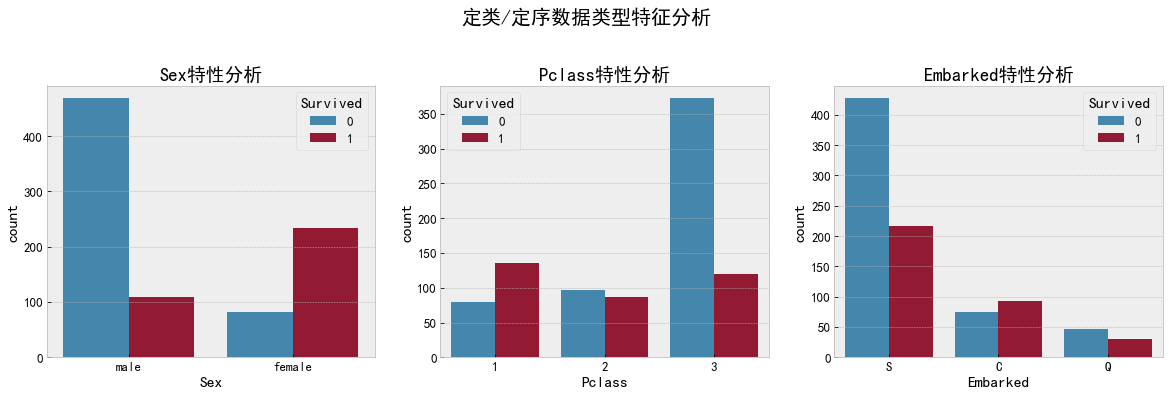

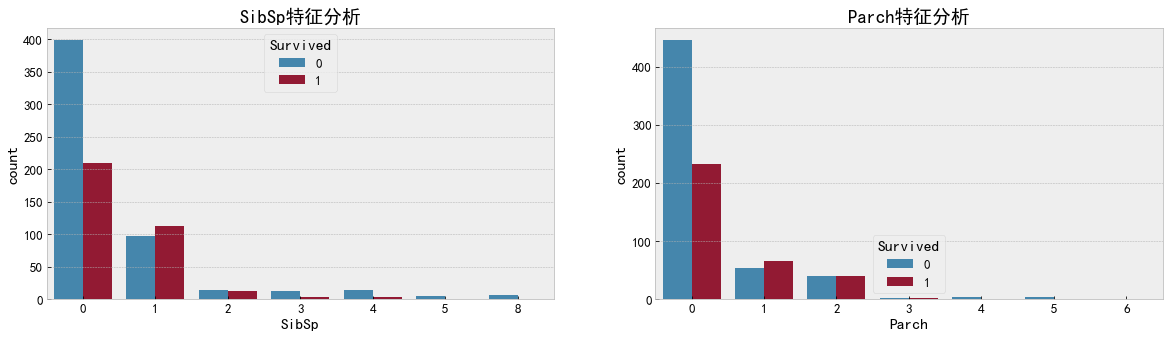

In [9]:
f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x='Sex',hue='Survived',data=data_train,ax=ax1)
sns.countplot(x='Pclass',hue='Survived',data=data_train,ax=ax2)
sns.countplot(x='Embarked',hue='Survived',data=data_train,ax=ax3)
ax1.set_title('Sex特性分析')
ax2.set_title('Pclass特性分析')
ax3.set_title('Embarked特性分析')
f.suptitle('定类/定序数据类型特征分析',size=20,y=1.1)

f,[ax1,ax2] = plt.subplots(1,2,figsize=(20,5))
sns.countplot(x='SibSp',hue='Survived',data=data_train,ax=ax1)
sns.countplot(x='Parch',hue='Survived',data=data_train,ax=ax2)
ax1.set_title('SibSp特征分析')
ax2.set_title('Parch特征分析')

plt.show()

通过上面的图示，我们可以清晰的观察到各特征值的分布情况，以及与目标变量之间的联系。
- **Sex：**由于先救妇女和儿童的原则，男性虽然总人数较多，但是获救比例不如女性。
- **Pclass：**社会等级3的老百姓人数是最多的，但是获救比例是比较低的。
- **Embarked：**登陆港口S的人数是最多的，但是获救率却是最低的，C是最高的。
- **SibSp：**兄弟姐妹数量最低的人数最多，相应的获救率也是最低的，为1的相对较高。
- **Parch：**情况基本同上，因为它俩有相关性。

Sex和Pclass这两个特征是非常有影响的两个。

以上只是简单地单独分析，还需要更深一步分析。

D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


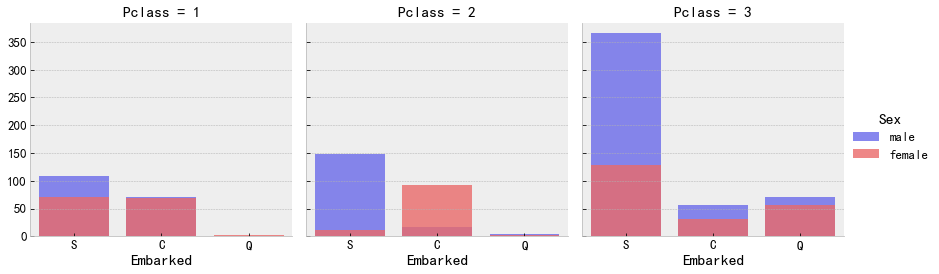

In [10]:
# 不同的社会等级下，男性和女性在不同登陆港口的数量对比
grid = sns.FacetGrid(df,col='Pclass',hue='Sex',palette='seismic',height=4)
grid.map(sns.countplot,'Embarked',alpha=0.8)
grid.add_legend()

**结论:**
- Pclass为1和2的时候，Q港口的数量几乎为零，而Pclass为3的Q港口人数明显多了起来，可以推测Q港口是社会等级较低的人聚居地，S和C是上层人士聚居地。
- Pclass为2的港口中，S和C呈现相反的趋势，S港口男性居多，C港口女性居多，这会影响生还率。

D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


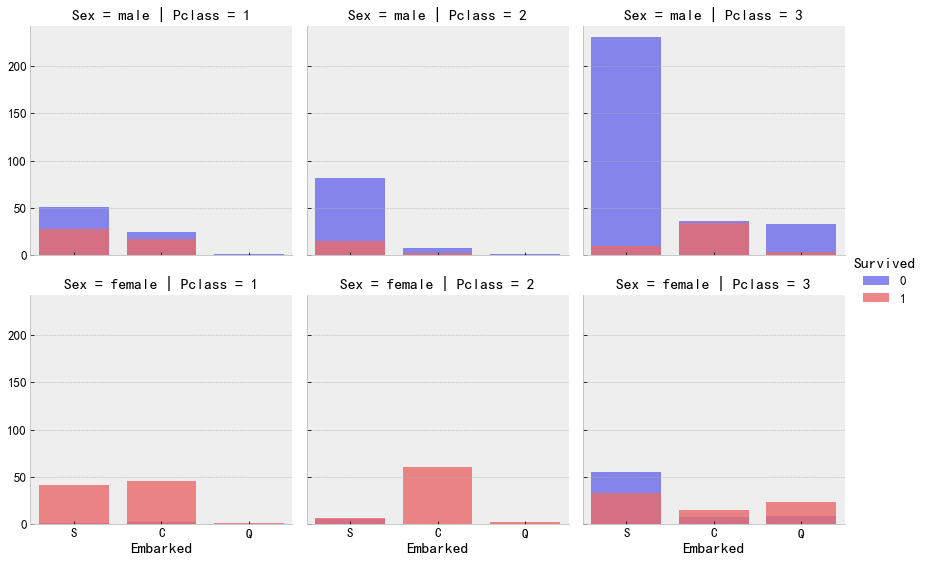

In [11]:
# 在不同的社会等级下，男性和女性在不同港口下的数量对比
grid = sns.FacetGrid(data_train,row='Sex',col='Pclass',hue='Survived',palette='seismic',height=4)
grid.map(sns.countplot, 'Embarked',alpha=0.8)
grid.add_legend()

### Age分布和特征分析

D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Frequency')

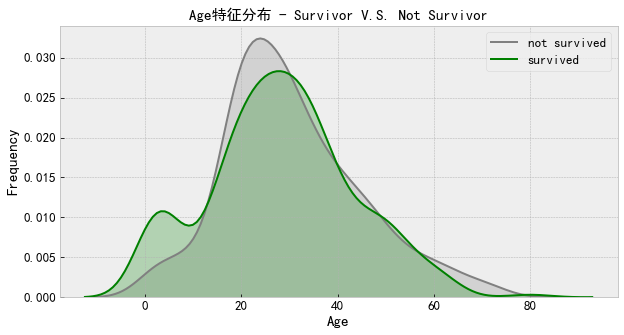

In [12]:
# kde分布
f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data_train.loc[(data_train['Survived']==0),'Age'],color='gray',shade=True,label='not survived')
sns.kdeplot(data_train.loc[(data_train['Survived']==1),'Age'],color='g',shade=True,label='survived')
plt.title('Age特征分布 - Survivor V.S. Not Survivor',fontsize=15)
plt.xlabel('Age',fontsize=15)
plt.ylabel('Frequency',fontsize=15)

**结论：**很明显可以看到，获救和没获救的区别主要在0-15岁左右，孩子的获救机率非常高，而成人则无明显区别。

D:\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


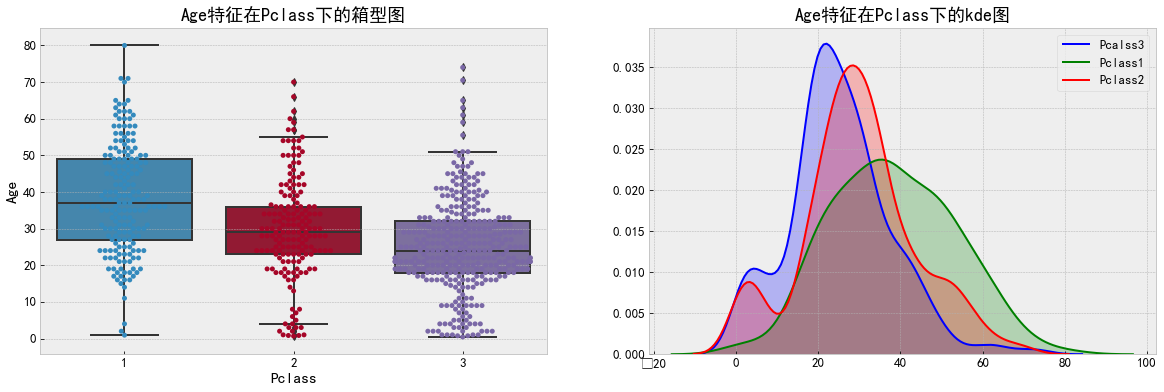

In [13]:
# 箱型图特征分析
f,[ax1,ax2] = plt.subplots(1,2,figsize=(20,6))
sns.boxplot(x='Pclass',y='Age',data=data_train,ax=ax1)
sns.swarmplot(x='Pclass',y='Age',data=data_train,ax=ax1)
sns.kdeplot(data_train.loc[(data_train['Pclass'] == 3),'Age'] , color='b',shade=True, label='Pcalss3',ax=ax2)
sns.kdeplot(data_train.loc[(data_train['Pclass'] == 1),'Age'] , color='g',shade=True, label='Pclass1',ax=ax2)
sns.kdeplot(data_train.loc[(data_train['Pclass'] == 2),'Age'] , color='r',shade=True, label='Pclass2',ax=ax2)
ax1.set_title('Age特征在Pclass下的箱型图',fontsize=18)
ax2.set_title('Age特征在Pclass下的kde图',fontsize=18)
f.show()

**结论：**不同Pclass下的年龄分布也不同，中位数按1，2，3排列，很符合实际情况，有一定财富和地位的成功人士年龄相对较大些，年轻人相对来说还没积累很多财富，而且人数也是最多的。

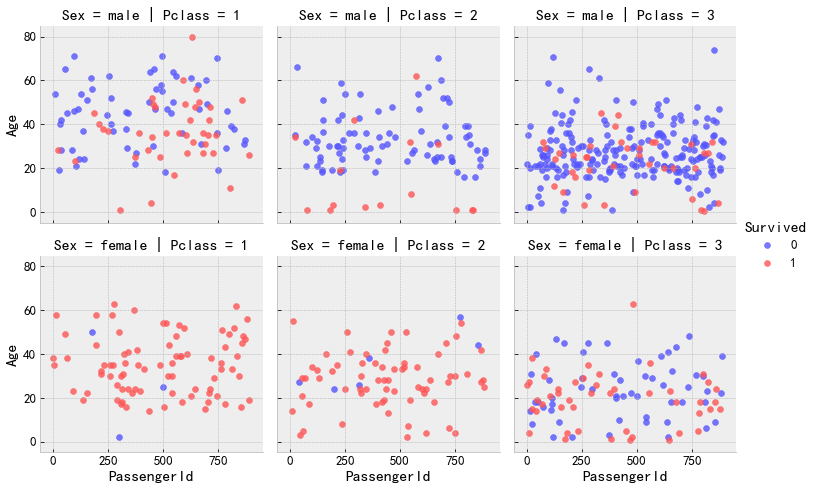

In [14]:
# Sex, Pclass分类条件下的Age年龄对Survived的散点图
grid = sns.FacetGrid(data_train,row='Sex',col='Pclass',hue='Survived',palette='seismic',height=3.5)
grid.map(plt.scatter,'PassengerId','Age',alpha=0.8)
grid.add_legend()

**结论：**
- Pclass1的男性生还率最高，Pclass2中的年龄小的几乎都生还了。
- Pclass1和2的女性几乎都生还了，Pclass3则没那么多生还的。

印证了上面说的原则，**妇女和孩子优先营救。**

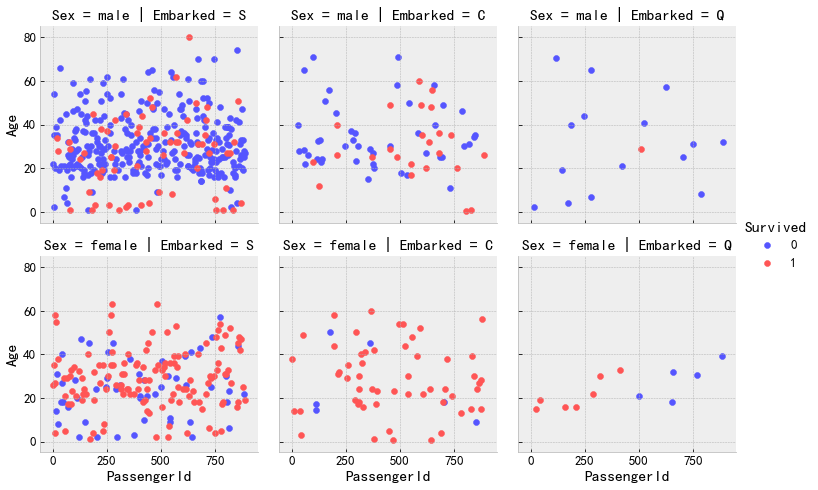

In [15]:
# Sex，Embarked分类条件下的 Age年龄对Survived的散点图
grid = sns.FacetGrid(data_train, row = "Sex",col = "Embarked", hue = "Survived", palette = 'seismic', height=3.5)
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

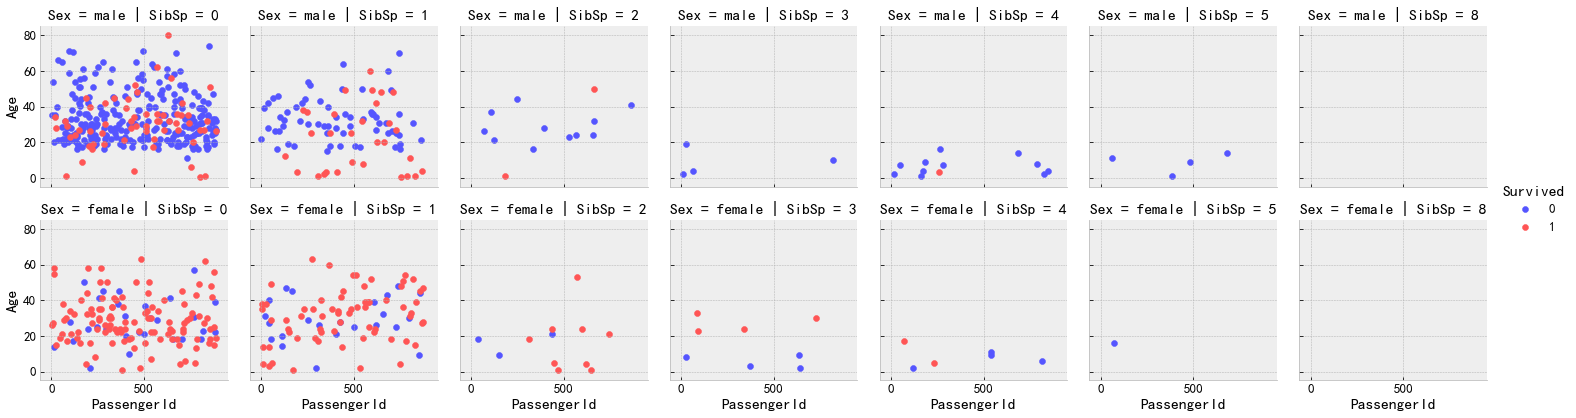

In [16]:
# Sex，SibSp分类条件下的 Age年龄对Survived的散点图
grid = sns.FacetGrid(data_train, col = "SibSp", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

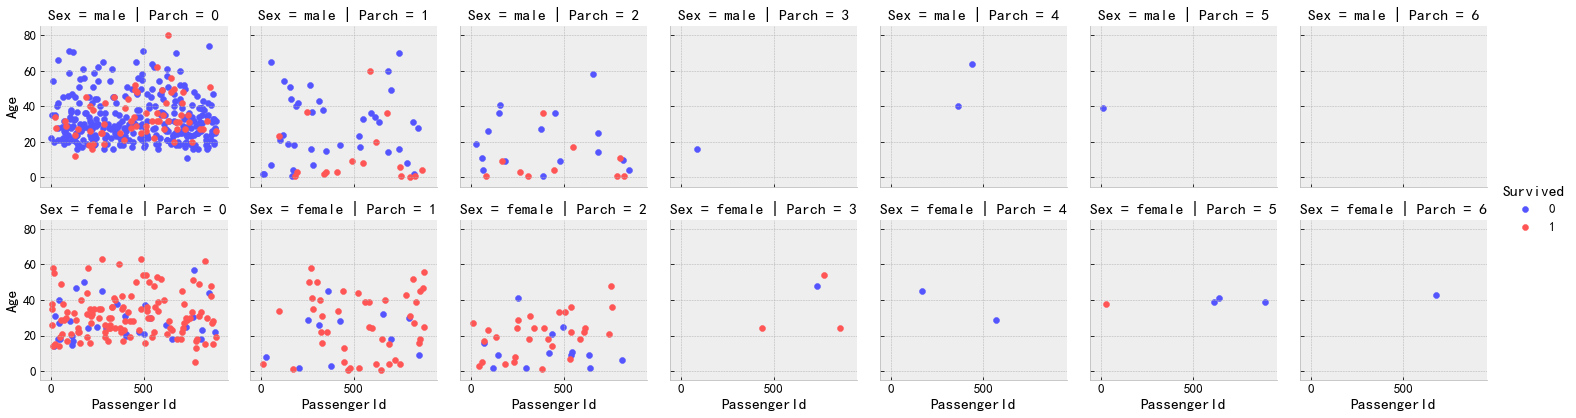

In [17]:
# Sex，Parch分类条件下的 Age年龄对Survived的散点图
grid = sns.FacetGrid(data_train, col = "Parch", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

### Fare分布和特征分析

D:\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


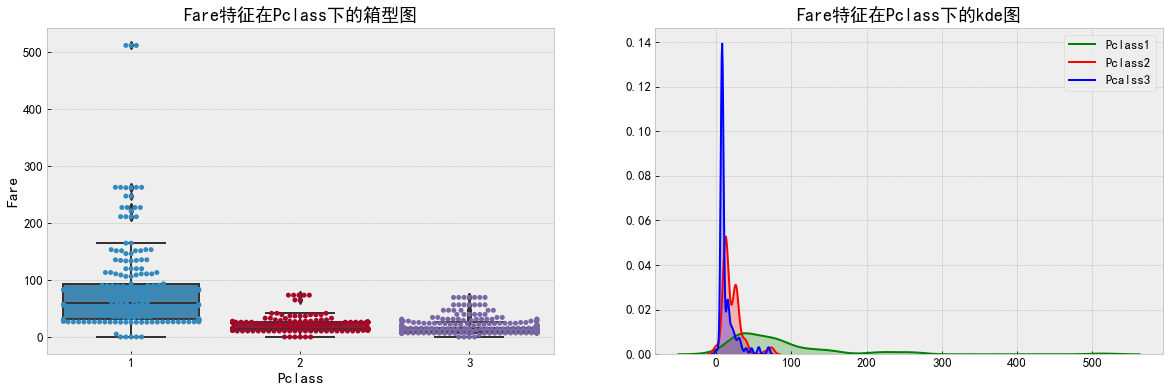

In [18]:
# 箱型图特征分析
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(20,6))
sns.boxplot(x="Pclass", y="Fare", data=data_train, ax =ax1)
sns.swarmplot(x="Pclass", y="Fare", data=data_train, ax =ax1)
sns.kdeplot(data_train.loc[(data_train['Pclass'] == 1),'Fare'] , color='g',shade=True, label='Pclass1',ax=ax2)
sns.kdeplot(data_train.loc[(data_train['Pclass'] == 2),'Fare'] , color='r',shade=True, label='Pclass2',ax=ax2)
sns.kdeplot(data_train.loc[(data_train['Pclass'] == 3),'Fare'] , color='b',shade=True, label='Pcalss3',ax=ax2)
ax1.set_title('Fare特征在Pclass下的箱型图', fontsize = 18)
ax2.set_title("Fare特征在Pclass下的kde图", fontsize = 18)
fig.show()

可以看到Pclass1相对于2和3的Fare比较高，属于财富和地位比较高的，但是Pclass1中有几个异常值。

In [19]:
df.loc[df['Fare']>500]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
258,35.0,NaN,C,512.3292,"Ward, Miss. Anna",0,259,1,female,0,1.0,PC 17755
679,36.0,B51 B53 B55,C,512.3292,"Cardeza, Mr. Thomas Drake Martinez",1,680,1,male,0,1.0,PC 17755
737,35.0,B101,C,512.3292,"Lesurer, Mr. Gustave J",0,738,1,male,0,1.0,PC 17755
343,58.0,B51 B53 B55,C,512.3292,"Cardeza, Mrs. James Warburton Martinez (Charlo...",1,1235,1,female,0,NaN,PC 17755


从名字和其他相同的属性可以看出有2个人可能是夫妻，这说明可能不是异常值，还需要进一步分析。

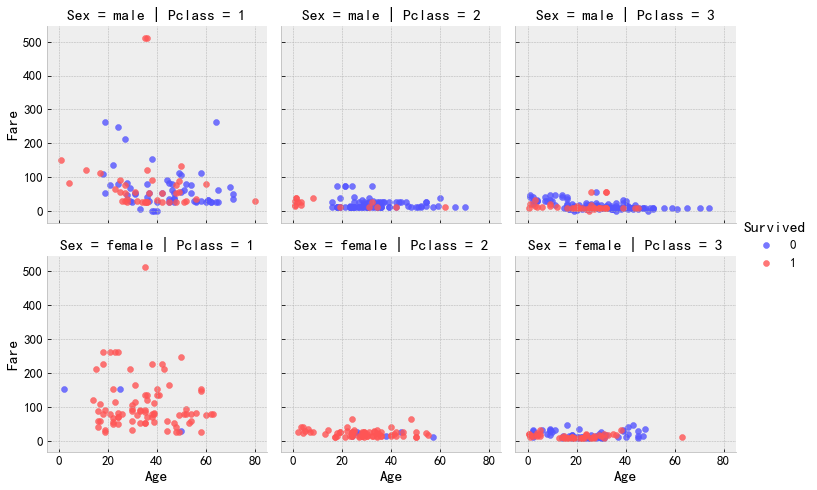

In [20]:
# Sex和Pclass情况下Fare和Age的散点图
grid = sns.FacetGrid(data_train, row='Sex', col='Pclass', hue='Survived', palette='seismic', height=3.5)
grid.map(plt.scatter, 'Age', 'Fare', alpha=0.8)
grid.add_legend()

D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


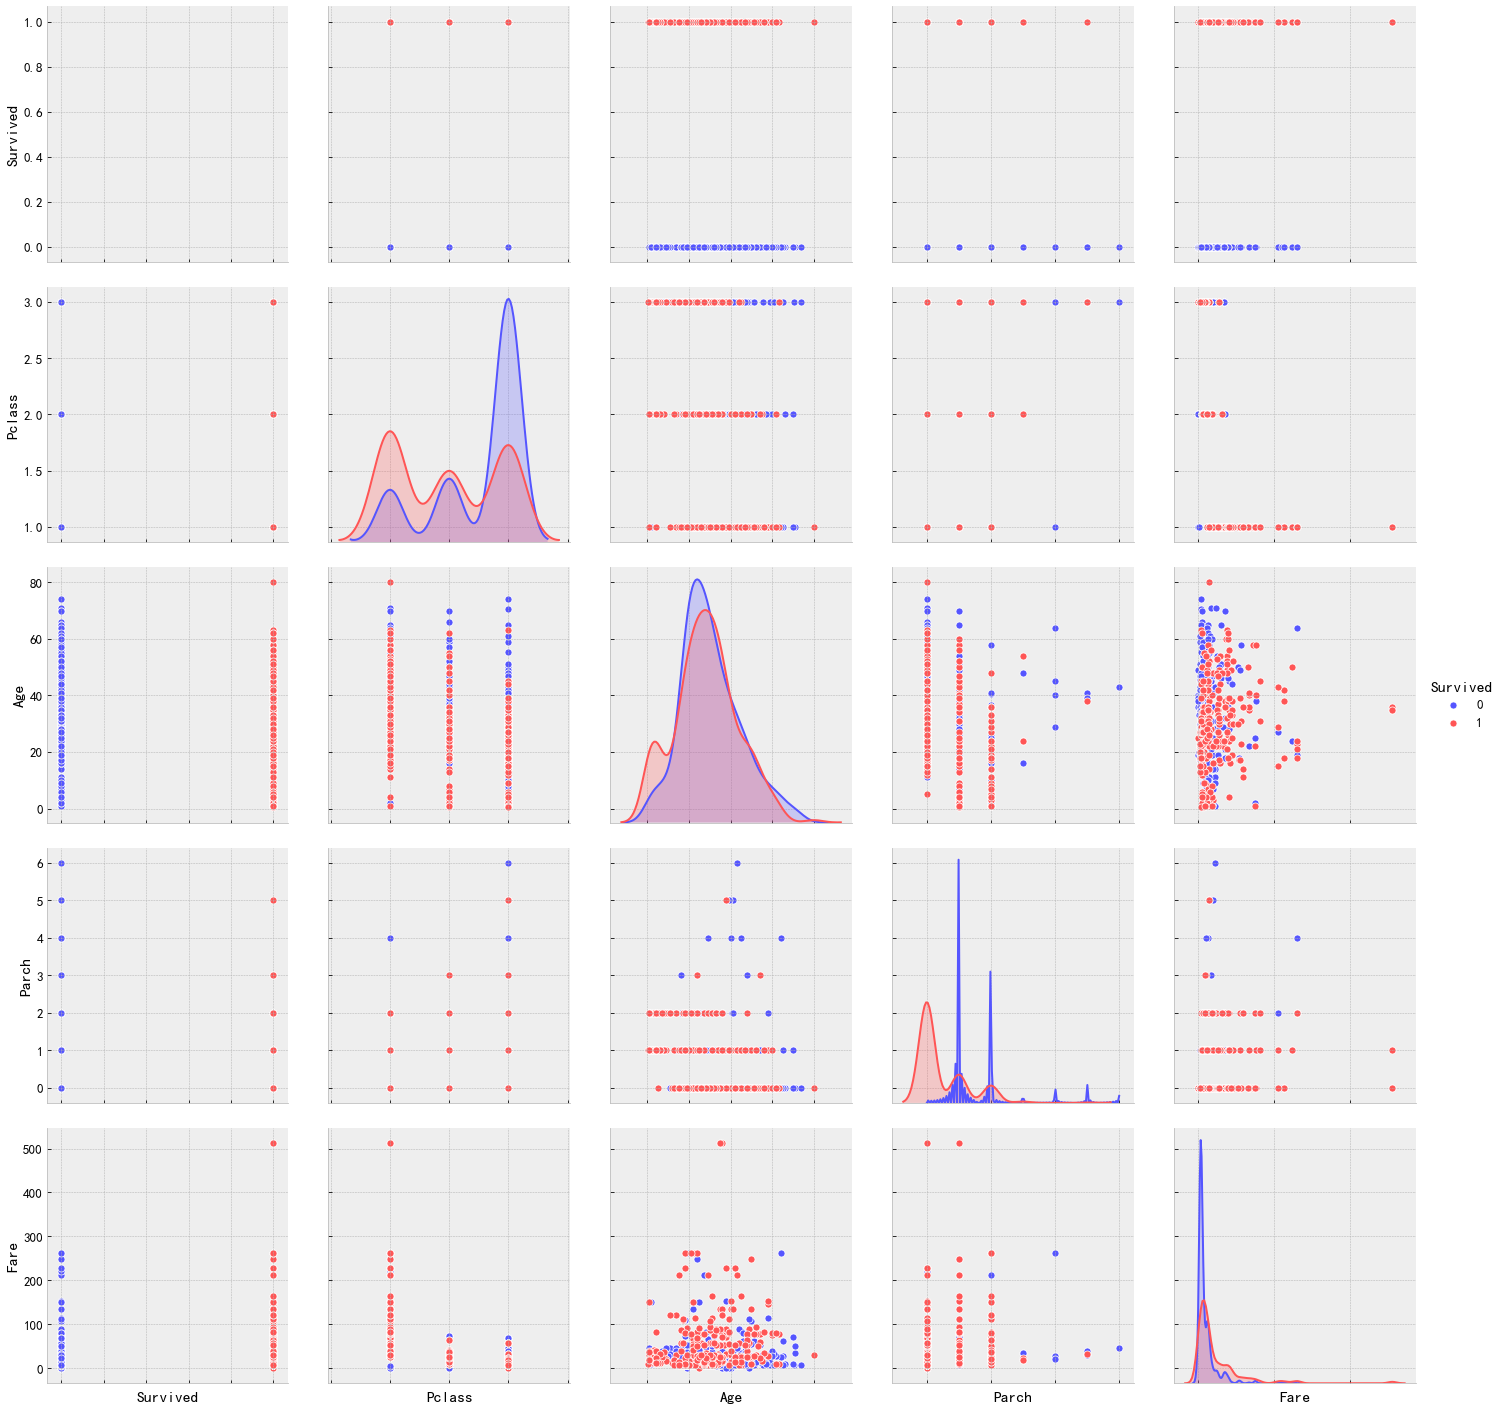

In [21]:
g = sns.pairplot(data_train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked']], hue='Survived', palette = 'seismic',
                 height=4,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])

这是上面7各特征的相互关联图的汇总，对角线为特征自身的kde分布。Name，Cabin，Ticket由于不方面可视化，还需要进一步挖掘这些数据的价值。

## 3. 数据预处理

我们需要做的一些事：
1. 对异常和缺失的数据进行清洗
2. 进行特征转换，比如性别特征可以转化为0和1
3. 除了提供的变量外，尝试做出一些便于分析和有用的「衍生变量」
4. 整理数据，建立一个模型，输出预测结果

### 数据清洗

In [22]:
# Fare缺失值处理
df[df['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


**Fare特征缺失值:**

只有一个缺失值，Pclass为3，年龄大于60的男性。可以考虑用其他值填补缺失值。

In [23]:
df.loc[(df['Pclass']==3)&(df['Age']>60)&(df['Sex']=='male')]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
116,70.5,NaN,Q,7.7500,"Connors, Mr. Patrick",0,117,3,male,0,0.0,370369
280,65.0,NaN,Q,7.7500,"Duane, Mr. Frank",0,281,3,male,0,0.0,336439
326,61.0,NaN,S,6.2375,"Nysveen, Mr. Johan Hansen",0,327,3,male,0,0.0,345364
851,74.0,NaN,S,7.7750,"Svensson, Mr. Johan",0,852,3,male,0,0.0,347060
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [24]:
# 提取出Name中的 Surname信息
df['surname'] = df["Name"].apply(lambda x: x.split(',')[0].lower())
fare_mean_estimated = df.loc[(df['Pclass']==3)&(df['Age']>60)&(df['Sex']=='male')].Fare.mean()
df.loc[df['surname']=='storey','Fare'] = fare_mean_estimated

**Embarked特征缺失值:**

In [25]:
# Embarked 缺失值处理
df[df['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,surname
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,icard
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,stone


上面分析过，Pclass为1且为女性的情况下，C港口最多，S其次，Q几乎为零，因此用C填补。

In [26]:
df['Embarked'] = df['Embarked'].fillna('C')

**Cabin特征缺失值：**

Cabin特征有70%的缺失值，不能进行填补，会引起噪声，因此将是否缺失作为一个新特征处理。

In [27]:
df['Cabin'].isnull().value_counts()

True     1014
False     295
Name: Cabin, dtype: int64

In [28]:
df['CabinCat'] = pd.Categorical(df.Cabin.fillna('0').apply(lambda x: x[0])).codes

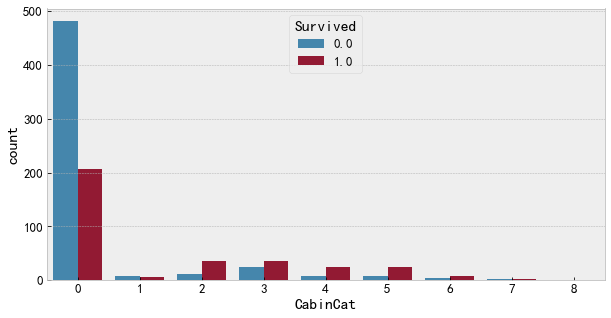

In [29]:
# data_train['CabinCat'] = data_train['Cabin'].copy()
# data_train.loc[(data_train.CabinCat.notnull()),'CabinCat'] = 'No'
# data_train.loc[(data_train.CabinCat.isnull()),'CabinCat'] = 'Yes'

f,ax = plt.subplots(figsize=(10,5))
sns.countplot(x='CabinCat',hue='Survived',data=df)
plt.show()

**结论：**Cabin缺失的生还率较低，明显低于于不缺失的。

**Age特征缺失值：**Age有20%缺失值，大量删减会减少样本信息，需要后续处理。

### 数据变换

**修正数据错误信息**

In [30]:
df.loc[df['surname']=='abbott',['Name','Sex','Age','SibSp','Parch']]

,Name,Sex,Age,SibSp,Parch
279,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1
746,"Abbott, Mr. Rossmore Edward",male,16.0,1,1
392,"Abbott, Master. Eugene Joseph",male,13.0,0,2


上面的数据看起来是不合理的，279和392的SibSp和Parch应该调换一下就可以了。

In [31]:
df.loc[(df['surname']=='abbott')&(df['Age']==35),'SibSp'] = 0
df.loc[(df['surname']=='abbott')&(df['Age']==35),'Parch'] = 2
df.loc[(df['surname']=='abbott')&(df['Age']==13),'SibSp'] = 1
df.loc[(df['surname']=='abbott')&(df['Age']==13),'Parch'] = 1

In [32]:
df.loc[df['surname']=='ford',['Name','Sex','Age','SibSp','Parch']]

,Name,Sex,Age,SibSp,Parch
86,"Ford, Mr. William Neal",male,16.0,1,3
147,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2
436,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2
736,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3
167,"Ford, Mr. Edward Watson",male,18.0,2,2
289,"Ford, Mr. Arthur",male,NaN,0,0


从数据可以看出，这是一位母亲带着4个孩子，最后一个可能是父亲。

In [33]:
df.loc[(df['surname']=='ford')&(df['Age']==16),'SibSp'] = 3
df.loc[(df['surname']=='ford')&(df['Age']==16),'Parch'] = 1
df.loc[(df['surname']=='ford')&(df['Age']==9),'SibSp'] = 3
df.loc[(df['surname']=='ford')&(df['Age']==9),'Parch'] = 1
df.loc[(df['surname']=='ford')&(df['Age']==21),'SibSp'] = 3
df.loc[(df['surname']=='ford')&(df['Age']==21),'Parch'] = 1
df.loc[(df['surname']=='ford')&(df['Age']==48),'SibSp'] = 0
df.loc[(df['surname']=='ford')&(df['Age']==48),'Parch'] = 4
df.loc[(df['surname']=='ford')&(df['Age']==18),'SibSp'] = 3
df.loc[(df['surname']=='ford')&(df['Age']==18),'Parch'] = 1

提取Name信息深入分析

In [34]:
# 从Name中提取Title信息，因为同为男性，Mr.和 Master.的生还率是不一样的
df["Title"] = df["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}

# 量化Title信息
df["TitleCat"] = df.loc[:,'Title'].map(title_mapping)

# 可视化分析看到SibSp和Parch分布相似，固将SibSp和Parch特征进行组合
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
# 根据FamilySize分布进行分箱
df["FamilySize"] = pd.cut(df["FamilySize"], bins=[0,1,4,20], labels=[0,1,2])

# 从Name特征衍生出Name的长度
df["NameLength"] = df["Name"].apply(lambda x: len(x))

# 量化Embarked特征
df["Embarked"] = pd.Categorical(df.Embarked).codes

# 对Sex特征进行独热编码分组
df = pd.concat([df,pd.get_dummies(df['Sex'])],axis=1)
# df = pd.concat([df,pd.get_dummies(df['Pclass'],prefix='Pclass')],axis=1)

In [35]:
# 给乘客分类，儿童、妇女、男士
child_age = 18
def get_passenger(passenger):
    age,sex = passenger
    if age < child_age:
        return 'child'
    elif sex == 'female':
        return 'female_adult'
    else:
        return 'male_adult'
    
df = pd.concat([df,pd.DataFrame(df[['Age','Sex']].apply(get_passenger,axis=1),columns=['person'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['person'])],axis=1)

In [36]:
# cabin奇偶性的特征
import re

def get_type_cabine(cabine):
    # 用正则表达式搜索title
    cabine_search = re.search('\d+',cabine)
    # 如果title存在，提取并返回
    
    if cabine_search:
        num=cabine_search.group(0)
        if np.float64(num)%2 ==0:
            return '2'
        else:
            return '1'
    return '0'

df['Cabin']=df['Cabin'].fillna(' ')
df['CabinType']=df['Cabin'].apply(get_type_cabine)
print(pd.value_counts(df['CabinType']))

0    1020
2     154
1     135
Name: CabinType, dtype: int64


In [37]:
# ticket的衍生特征
table_ticket = pd.DataFrame(df["Ticket"].value_counts())
table_ticket.rename(columns={'Ticket':'Ticket_Numbers'}, inplace=True)
table_ticket['Ticket_dead_women'] = df.Ticket[(df.female_adult == 1.0) 
                                    & (df.Survived == 0.0) 
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()

table_ticket['Ticket_dead_women'] = table_ticket['Ticket_dead_women'].fillna(0)
table_ticket['Ticket_dead_women'][table_ticket['Ticket_dead_women'] > 0] = 1.0

table_ticket['Ticket_surviving_men'] = df.Ticket[(df.male_adult == 1.0) 
                                    & (df.Survived == 1.0) 
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()

table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1.0 

# Ticket特征量化
table_ticket["Ticket_Id"] = pd.Categorical(table_ticket.index).codes

table_ticket["Ticket_Id"][table_ticket["Ticket_Numbers"] < 3 ] = -1
# Ticket数量分箱
table_ticket["Ticket_Numbers"] = pd.cut(table_ticket["Ticket_Numbers"], bins=[0,1,4,20], labels=[0,1,2])

df = pd.merge(df, table_ticket, left_on="Ticket",right_index=True, how='left', sort=False)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
# surname衍生特征
table_surname = pd.DataFrame(df["surname"].value_counts())
table_surname.rename(columns={'surname':'Surname_Numbers'}, inplace=True)

table_surname['Surname_dead_women'] = df.surname[(df.female_adult == 1.0) 
                                    & (df.Survived == 0.0) 
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
table_surname['Surname_dead_women'] = table_surname['Surname_dead_women'].fillna(0)
table_surname['Surname_dead_women'][table_surname['Surname_dead_women'] > 0] = 1.0 

table_surname['Surname_surviving_men'] = df.surname[(df.male_adult == 1.0) 
                                    & (df.Survived == 1.0) 
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1.0 

table_surname["Surname_Id"]= pd.Categorical(table_surname.index).codes

# surname数量分箱
table_surname["Surname_Id"][table_surname["Surname_Numbers"] < 3 ] = -1

table_surname["Surname_Numbers"] = pd.cut(table_surname["Surname_Numbers"], bins=[0,1,4,20], labels=[0,1,2])

df = pd.merge(df, table_surname, left_on="surname",right_index=True,how='left', sort=False)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'surname', 'CabinCat',
       'Title', 'TitleCat', 'FamilySize', 'NameLength', 'female', 'male',
       'person', 'child', 'female_adult', 'male_adult', 'CabinType',
       'Ticket_Numbers', 'Ticket_dead_women', 'Ticket_surviving_men',
       'Ticket_Id', 'Surname_Numbers', 'Surname_dead_women',
       'Surname_surviving_men', 'Surname_Id'],
      dtype='object')

对Age缺失值的处理

In [40]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor

classers = ['Fare','Parch','Pclass','SibSp','TitleCat', 
            'CabinCat','female','male', 'Embarked', 'FamilySize', 'NameLength','Ticket_Numbers','Ticket_Id']
etr = ExtraTreesRegressor(n_estimators=200,random_state=0)
X_train = df[classers][df['Age'].notnull()]
Y_train = df['Age'][df['Age'].notnull()]
X_test = df[classers][df['Age'].isnull()]

etr.fit(X_train.values,np.ravel(Y_train))
age_preds = etr.predict(X_test.values)
df['Age'][df['Age'].isnull()] = age_preds

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


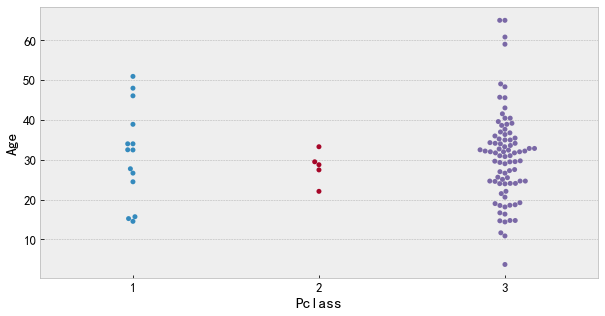

In [41]:
# Age缺失值填补后的情况
X_test['Age'] = pd.Series(age_preds)
f,ax=plt.subplots(figsize=(10,5))
sns.swarmplot(x='Pclass',y='Age',data=X_test)
plt.show()

### 逻辑回归算法

In [42]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [43]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
data_train['Age'].isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [45]:
# Age列中的缺失值用中位数进行填充
data_train['Age'] = data_train['Age'].fillna(data_train['Age'].median())
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [46]:
from sklearn import model_selection
# 逻辑回归
from sklearn.linear_model import LogisticRegression

# 选取简单的可用输入特征
predictors = ['Pclass','Age','SibSp','Parch','Fare']

# 初始化逻辑回归算法
LogRegAlg = LogisticRegression()
LogRegAlg.fit(data_train[predictors],data_train['Survived'])

# 使用交叉验证函数获取预测准确率分数
scores = model_selection.cross_val_score(LogRegAlg,data_train[predictors],data_train['Survived'],cv=3)

# 使用交叉验证分数的平均值作为最终的准确率
print('准确率：',scores.mean())

准确率： 0.6992143658810326


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 增加Sex特征和Embarked特征列
对Sex和Embarked进行处理

In [47]:
# Sex列处理，male用0表示，female用1表示
data_train.loc[data_train['Sex']=='male','Sex'] = 0
data_train.loc[data_train['Sex']=='female','Sex'] = 1

# 前面看到Embarked缺失值有2个，用数量最多的S进行填充
data_train['Embarked'] = data_train['Embarked'].fillna('S')
# 这三个登船港口用0，1，2表示
data_train.loc[data_train['Embarked']=='S','Embarked'] = 0
data_train.loc[data_train['Embarked']=='C','Embarked'] = 1
data_train.loc[data_train['Embarked']=='Q','Embarked'] = 2

In [48]:
predictors = ['Pclass','Age','SibSp','Parch','Fare','Sex','Embarked']

# 初始化逻辑回归算法
LogRegAlg = LogisticRegression()
LogRegAlg.fit(data_train[predictors],data_train['Survived'])

# 使用交叉验证函数获取预测准确率分数
scores = model_selection.cross_val_score(LogRegAlg,data_train[predictors],data_train['Survived'],cv=3)

# 使用交叉验证分数的平均值作为最终的准确率
print('准确率：',scores.mean())

准确率： 0.7878787878787877


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


准确率提高了很多，说明选取合适的特征有利于提升模型的预测能力。

In [49]:
data_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [50]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [51]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [52]:
# 对测试集进行生还预测
# 对Age列中的缺失值用中值进行填充
data_test['Age'] = data_test['Age'].fillna(data_test['Age'].median())
# Fare列中的缺失值用最大值进行填充
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].max())

# Sex列处理，male用0表示，female用1表示
data_test.loc[data_test['Sex']=='male','Sex'] = 0
data_test.loc[data_test['Sex']=='female','Sex'] = 1

# 这三个登船港口用0，1，2表示
data_test.loc[data_test['Embarked']=='S','Embarked'] = 0
data_test.loc[data_test['Embarked']=='C','Embarked'] = 1
data_test.loc[data_test['Embarked']=='Q','Embarked'] = 2

test_featrues = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

# 构造测试集的Survived列
data_test['Survived'] = -1

test_predictors = data_test[test_featrues]
data_test['Survived'] = LogRegAlg.predict(test_predictors)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
data_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2,1
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0,1
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,0,0,7538,9.2250,NaN,0,1
6,898,3,"Connolly, Miss. Kate",1,30.0,0,0,330972,7.6292,NaN,2,1
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,1,1,248738,29.0000,NaN,0,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,18.0,0,0,2657,7.2292,NaN,1,1
9,901,3,"Davies, Mr. John Samuel",0,21.0,2,0,A/4 48871,24.1500,NaN,0,1


### 随机森林预测生还率

特征选择

In [55]:
from sklearn.feature_selection import SelectKBest, f_classif,chi2

target = data_train["Survived"].values
features= ['female','male','Age','male_adult','female_adult', 'child','TitleCat',
           'Pclass','Ticket_Id','NameLength','CabinType','CabinCat', 'SibSp', 'Parch',
           'Fare','Embarked','Surname_Numbers','Ticket_Numbers','FamilySize',
           'Ticket_dead_women','Ticket_surviving_men',
           'Surname_dead_women','Surname_surviving_men']

train = df[0:891].copy()
test = df[891:].copy()

selector = SelectKBest(f_classif, k=len(features))
selector.fit(train[features], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],features[indices[f]]))

Features importance :
68.85 female
68.85 male
64.90 male_adult
53.23 female_adult
26.22 TitleCat
24.60 Pclass
23.69 NameLength
17.75 CabinCat
17.00 Ticket_surviving_men
16.28 CabinType
14.21 Fare
13.54 Ticket_dead_women
13.04 Surname_surviving_men
10.36 Surname_dead_women
6.78 Embarked
5.27 Ticket_Numbers
3.59 child
2.93 FamilySize
2.02 Parch
1.66 Age
1.07 Ticket_Id
0.73 Surname_Numbers
0.61 SibSp


In [56]:
# features_selected = []
# for f in range(len(scores)):
#     if scores[indices[f]]>=1:
#         features_selected.append(features[indices[f]])

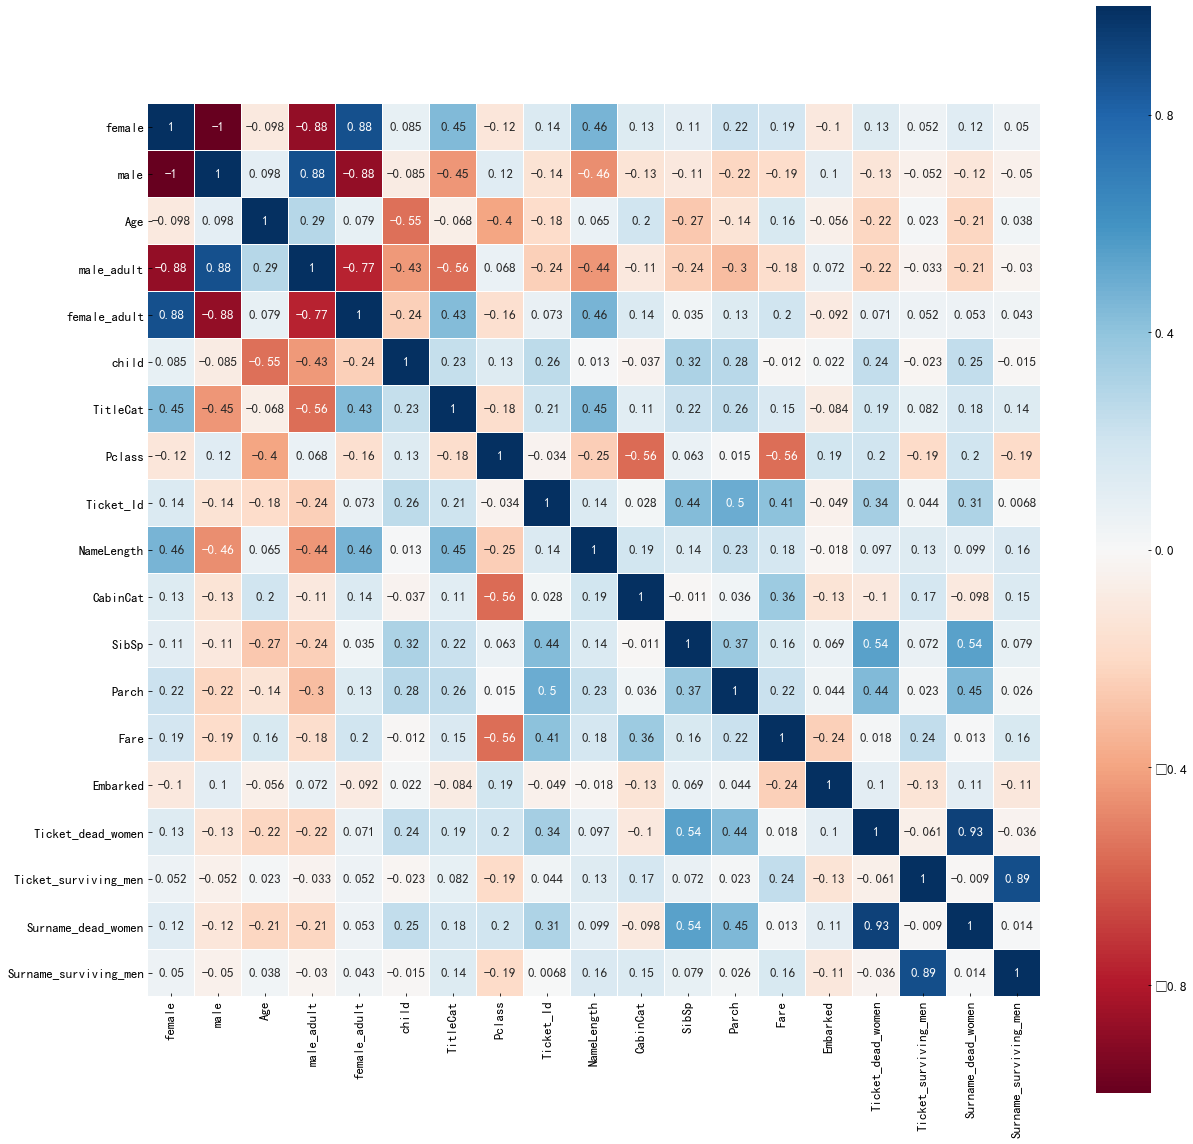

In [57]:
features_selected = features
# data_corr 
df_corr = df[features_selected].copy()

colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
sns.heatmap(df_corr.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [58]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier

rfc = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745,1:0.255})
# rfc = AdaBoostClassifier(n_estimators=3000, learning_rate=0.1, random_state=1)

# 交叉验证，建模随机森林
kf = model_selection.KFold(n_splits=3, random_state=1)

scores = model_selection.cross_val_score(rfc, train[features_selected], target, cv=kf)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean()*100, scores.std()*100, 'RFC Cross Validation'))
rfc.fit(train[features_selected], target)
score = rfc.score(train[features_selected], target)
print("Accuracy: %0.3f            [%s]" % (score*100, 'RFC full test'))
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features_selected)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f]+1, importances[indices[f]]*100, features_selected[indices[f]]))


# 预测目标值
rfc.fit(train[features_selected], target)
predictions = rfc.predict(test[features_selected])

Accuracy: 89.450 (+/- 0.79) [RFC Cross Validation]
Accuracy: 96.521            [RFC full test]
1. feature 15 (9.627365) Fare
2. feature 3 (9.148878) Age
3. feature 10 (8.621512) NameLength
4. feature 20 (8.120330) Ticket_dead_women
5. feature 22 (7.029765) Surname_dead_women
6. feature 7 (6.793364) TitleCat
7. feature 2 (6.534039) male
8. feature 1 (6.082080) female
9. feature 8 (5.101747) Pclass
10. feature 4 (4.680282) male_adult
11. feature 21 (4.571799) Ticket_surviving_men
12. feature 5 (3.712038) female_adult
13. feature 18 (2.889583) Ticket_Numbers
14. feature 12 (2.731237) CabinCat
15. feature 23 (2.439303) Surname_surviving_men
16. feature 19 (2.384045) FamilySize
17. feature 17 (1.963780) Surname_Numbers
18. feature 11 (1.894365) CabinType
19. feature 16 (1.674688) Embarked
20. feature 9 (1.328829) Ticket_Id
21. feature 13 (1.274838) SibSp
22. feature 14 (0.724974) Parch
23. feature 6 (0.671158) child


In [61]:
# 输出文件
PassengerId =np.array(test["PassengerId"]).astype(int)
my_prediction = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])

my_prediction.to_csv("my_prediction.csv", index_label = ["PassengerId"])